<a href="https://colab.research.google.com/github/FoobarProtocol/notes_and_docs/blob/main/eztoolbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div id="job_title"> 
    <h1  style="color:Green; font-family:Baskerville"><b>This is a notebook for referencing everyday tools for ML engineering</h1>
</div>

# Data preprocessing

##Reading CSV files

In [ ]:
import pandas as pd
df1 = pd.read_csv('/content/sample_data/california_housing_test.csv')

##Removing NA values

In [ ]:
df1 =df1.dropna()

## Visualizing dataset correlation

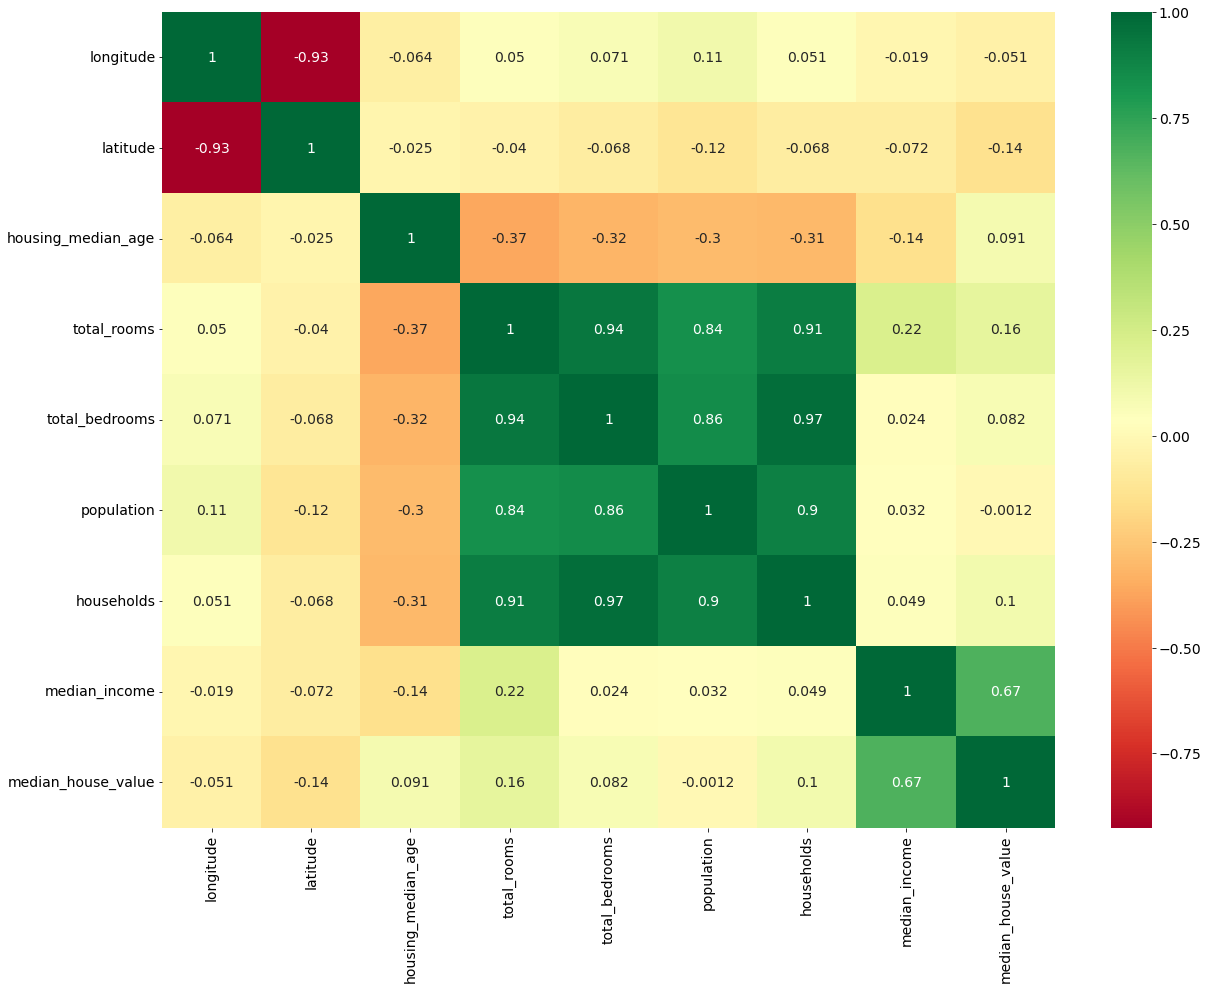

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

corr = df1.corr()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr, annot=True,cmap="RdYlGn")
ax

##Separating training and test data

In [ ]:
X = df1.copy()
X.pop('median_house_value')
y = df1.median_house_value.copy()

In [ ]:
from sklearn.model_selection import train_test_split
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

##Normalizing data

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
X_train = sc.fit_transform(X_train) #Create standardization and apply to train data
X_test = sc.transform(X_test)       #Apply created standardization to new data
X_val = sc.transform(X_val)         #Apply created standardization to new data

##Principal component analysis

In [ ]:
from sklearn.decomposition import PCA
  
pca = PCA(n_components = 0.9, svd_solver='full')
  
X_train = pca.fit_transform(X_train) #Create PCA and apply to train data
X_test = pca.transform(X_test)       #Apply created PCA to new data
X_val = pca.transform(X_val)         #Apply created normalization to new data

# Model training

##Calculate model resuts function

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def calculate_results(y_true, y_pred):
    model_mae = mean_absolute_error(y_true, y_pred)
    model_mse = mean_squared_error(y_true, y_pred)
    model_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    model_r2 = r2_score(y_true, y_pred)
    model_rmsle = np.log(np.sqrt(mean_squared_error(y_true, y_pred)))
    
    
    model_results = {"Mean Absolute Error (MAE)": model_mae,
                     "Mean Squared Error (MSE)": model_mse,
                     "Root Mean Squared Error (RMSE)": model_rmse,
                     "Adjusted R^2 Score": model_r2,
                     "Root Mean Squared Log Error": model_rmsle}
    return model_results

##Example models

###Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
model = rf.fit(X_train, y_train)
y_pred = model.predict(X_val)
rf_results = calculate_results(y_val, y_pred)
results = pd.DataFrame(rf_results, index=['Random Forest']).T

predictions = pd.DataFrame(y_val.reset_index(drop=True)).rename(columns={'MEDV':'Validation'})

data = {
    'Random Forest':y_pred
}
predictions['Random Forest'] = pd.DataFrame(data)

###Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42) 

model = gbr.fit(X_train, y_train)
y_pred = model.predict(X_val)
gbr_results = calculate_results(y_val, y_pred)
results['Gradient Boosting'] = pd.DataFrame(gbr_results, index=['Gradient Boosting']).T

data = {
    'Gradient Boosting':y_pred
}
predictions['Gradient Boosting'] = pd.DataFrame(data)

###LGBM

In [ ]:
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

y_pred = lightgbm.fit(X_train, y_train).predict(X_val)
lightgbm_results = calculate_results(y_val, y_pred)
results['LGBM'] = pd.DataFrame(lightgbm_results, index=['LGBM']).T

data = {
    'LGBM':y_pred
}

predictions['LGBM'] = pd.DataFrame(data)

###Keras Neural Network

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Normalization

model = Sequential()
model.add(Dense(50, input_shape=(X_train.shape[1],)))
model.add(Dense(2))
model.add(Dense(1))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['msle'])

model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0)

y_pred = model.predict(X_val)
sequential_results = calculate_results(y_val, y_pred)
results['Neural Network'] = pd.DataFrame(sequential_results, index=['Neural Network']).T

y_pred = y_pred.reshape(y_pred.shape[0],)

data = {
    'Neural Network':y_pred
}
predictions['Neural Network'] = pd.DataFrame(data)

19/19 [==============================] - 0s 1ms/step


#Visualizing results

In [ ]:
results

,Random Forest,Gradient Boosting,LGBM,Neural Network
Mean Absolute Error (MAE),5.587536e+04,5.657316e+04,6.239367e+04,2.094138e+05
Mean Squared Error (MSE),5.920473e+09,6.213070e+09,7.080527e+09,5.638047e+10
Root Mean Squared Error (RMSE),7.694461e+04,7.882303e+04,8.414587e+04,2.374457e+05
Adjusted R^2 Score,5.273584e-01,5.039999e-01,4.347494e-01,-3.500950e+00
Root Mean Squared Log Error,1.125084e+01,1.127496e+01,1.134031e+01,1.237769e+01


##Plotly scatter plot

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.update_layout(title_text="Models predictions",
                  title_font_size=30,
                  title_x=0.5)

for model in predictions:
    if model == 'Validation': continue
    fig.add_trace(go.Scatter(x=np.sort(y_test), y=predictions[model].sort_values(),
                    mode='markers',
                    name=model))

fig.add_trace(go.Scatter(x=np.sort(y_test), y=np.sort(y_test),
                    mode='lines',
                    name='Expected results'))